# Leios simulation analysis at tag `leios-2025w27`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: 1000 TPS with small transactions and varied time step

In [2]:
label <- "Rust simulator, mini-mainnet, full-tx-with-references, 1000 TPS, 2.5 EB/stage, 2.0 IB/slot, sharded"

### Analysis of simulation timestep

#### Read the lifecycle results

In [3]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(lifecycle, sampleSize, file="results/lifecycle.R")
}
lifecycle %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator       timestamp-resolution-ms Kind                   Item        
 Rust:1243328   dt = 0.025 ms:621664     EB:   1186   0           :      2  
                dt = 0.100 ms:621664     IB:   4590   1           :      2  
                                         RB:    150   1-node-158-0:      2  
                                         TX:1237402   1-node-209-0:      2  
                                                      1-node-498-0:      2  
                                                      10          :      2  
                                                      (Other)     :1243316  
    Size [B]         References       Created [s]        To IB [s]      
 Min.   :  300.0   Min.   :  0.000   Min.   :   1.13   Min.   :  61.13  
 1st Qu.:  300.0   1st Qu.:  1.000   1st Qu.: 210.38   1st Qu.: 261.13  
 Median :  300.0   Median :  1.000   Median : 360.31   Median : 420.13  
 Mean   :  338.5   Mean   :  1.174   Mean   : 361.27   Mean   : 426.05  
 3rd Qu.:  300.0   

#### Range of transaction injection

In [4]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst
simFinish <- 1200

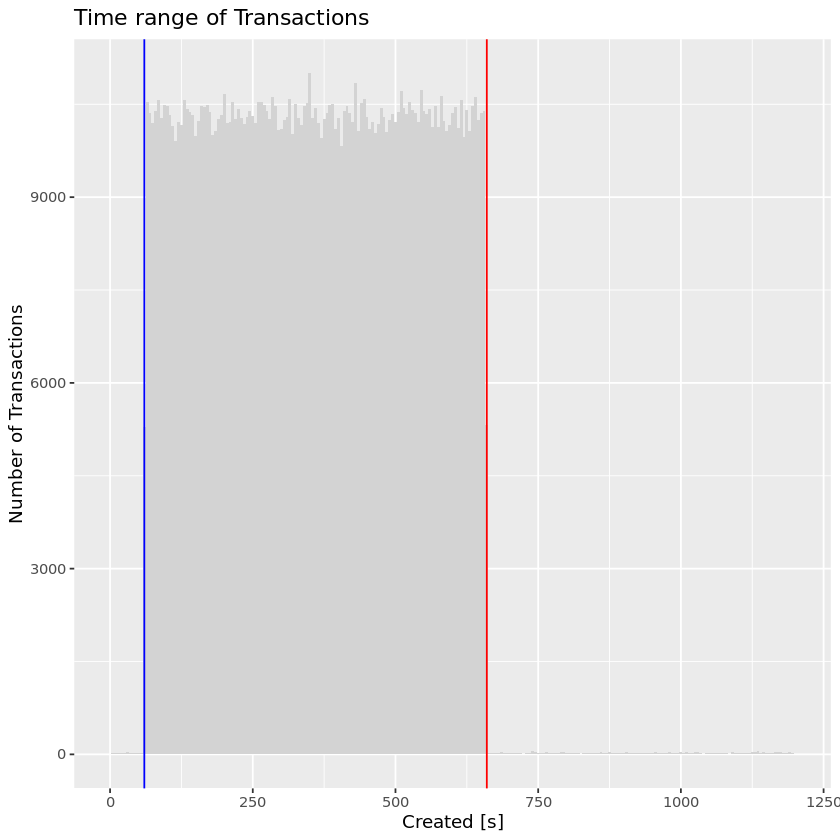

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [Mb/s]`=8*sum(`Size [B]`)/1e6/txWindow,
        `Transaction size [B/tx]`=sum(`Size [B]`)/.N
    ),
    .(`timestamp-resolution-ms`)
]

timestamp-resolution-ms,Demand [tx/s],Demand [MB/s],Demand [Mb/s],Transaction size [B/tx]
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
dt = 0.100 ms,1031.168,0.3093505,2.474804,300
dt = 0.025 ms,1031.168,0.3093505,2.474804,300


#### Size of persisted data

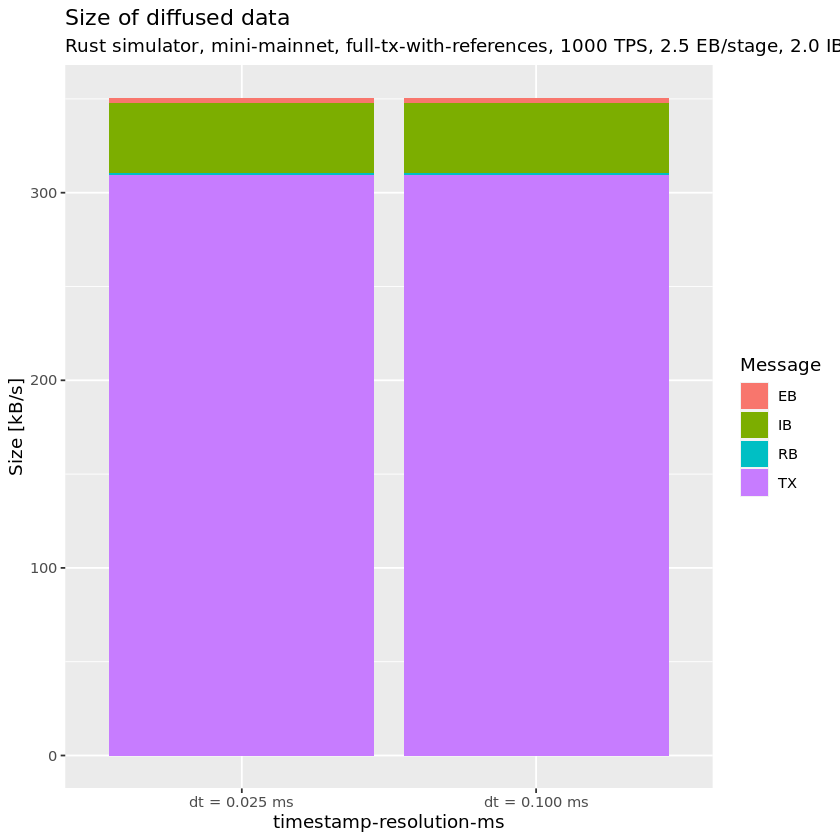

In [7]:
ggplot(
    lifecycle[,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        .(`timestamp-resolution-ms`, `Message`=`Kind`)
    ],
    aes(x=`timestamp-resolution-ms`, y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    ggtitle("Size of diffused data", subtitle=label)

In [8]:
ggsave("plots/sizes.png", units="in", dpi=150, width=16, height=8)

#### Time to reach the EB

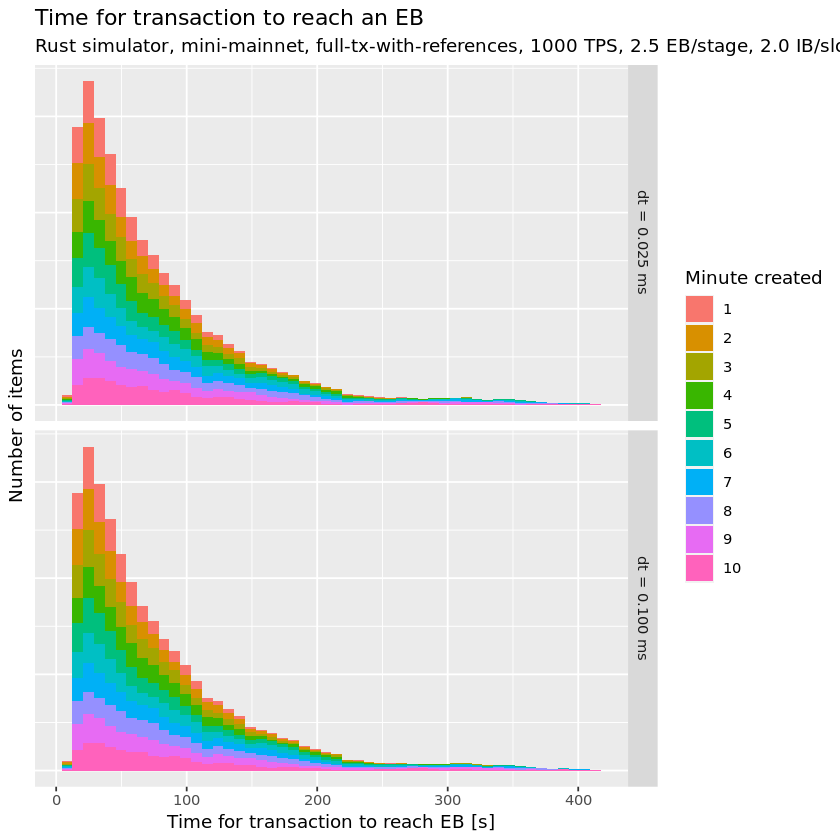

In [9]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
        .(`timestamp-resolution-ms`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
#   scale_x_log10() +
    facet_grid(`timestamp-resolution-ms` ~ ., scales="free_y") +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach an EB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [10]:
ggsave("plots/reach-eb-tx.png", units="in", dpi=150, width=16, height=8)

#### Time to reach the ledger

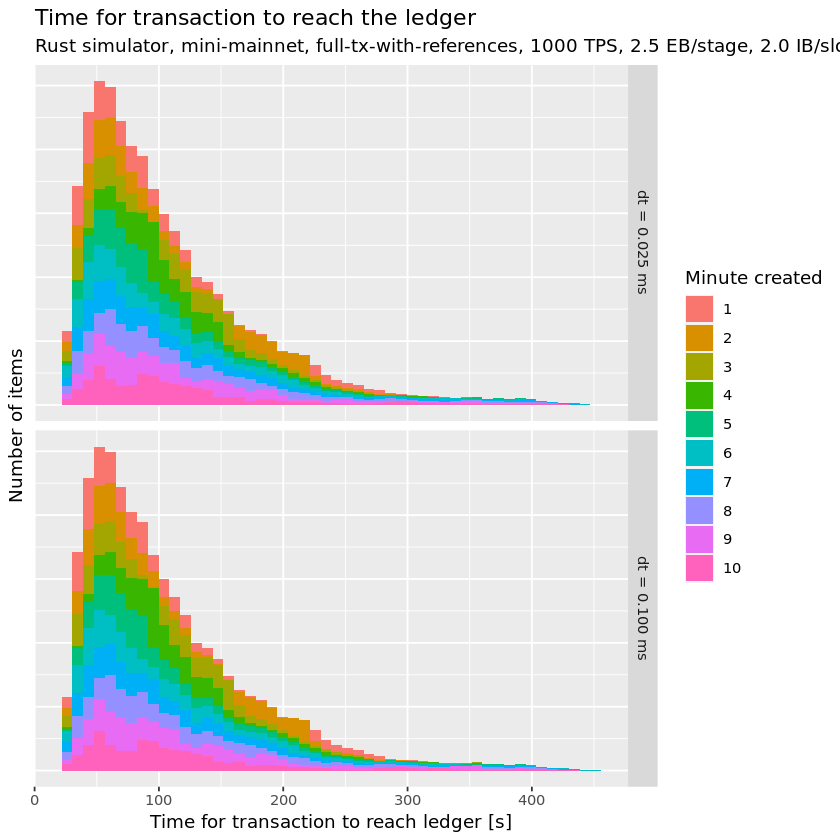

In [11]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`timestamp-resolution-ms`, `Kind`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
#   scale_x_log10() +
    facet_grid(`timestamp-resolution-ms` ~ ., scales="free_y") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [12]:
ggsave("plots/reach-rb-tx.png", units="in", dpi=150, width=16, height=8)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

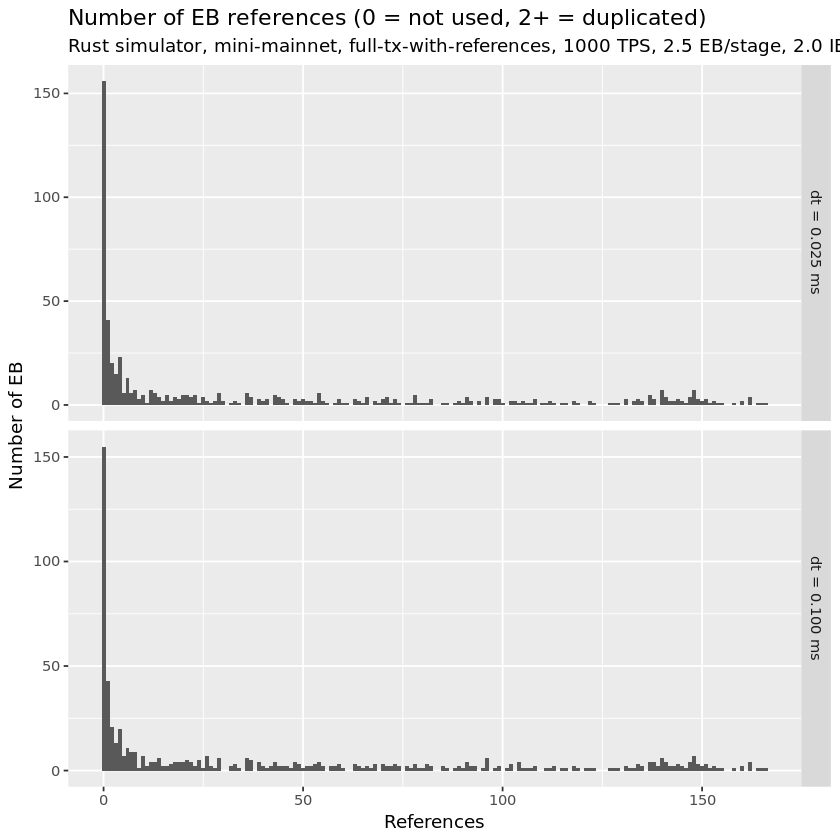

In [13]:
ggplot(
    lifecycle[
        `Kind` == "EB",
        .(`References`),
        .(`timestamp-resolution-ms`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`timestamp-resolution-ms` ~ ., scales="free_y") +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [14]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=16, height=8)

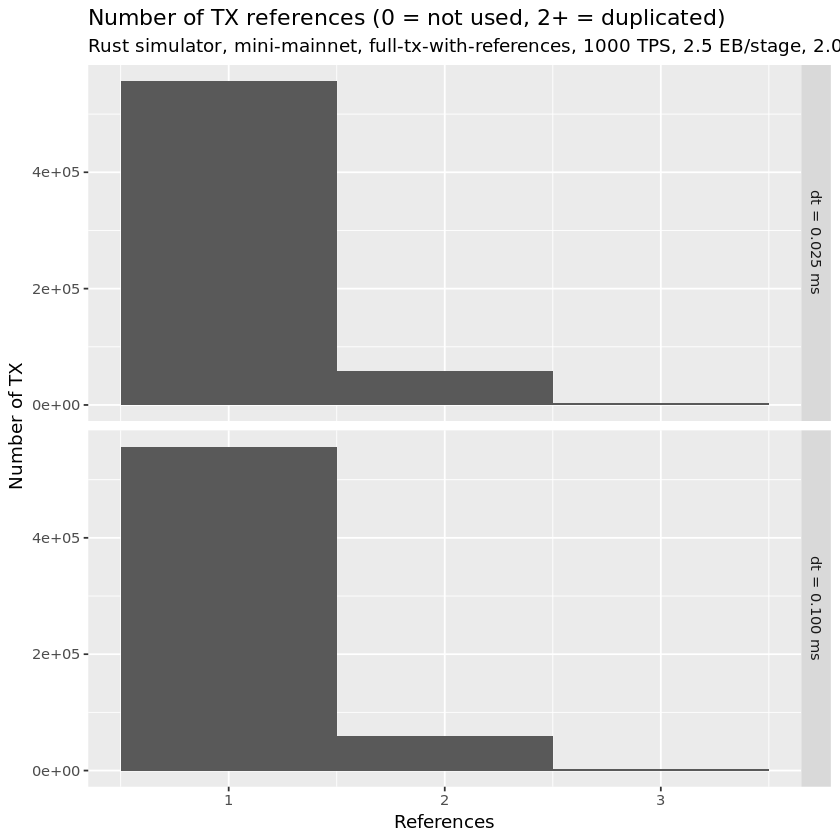

In [15]:
ggplot(
    lifecycle[
        `Kind` == "TX",
        .(`References`),
        .(`timestamp-resolution-ms`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`timestamp-resolution-ms` ~ ., scales="free_y") +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)", label)

In [16]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=16, height=8)

#### Temporal efficiency

In [17]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [18]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `timestamp-resolution-ms`
    )
][order(`timestamp-resolution-ms`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [19]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`timestamp-resolution-ms`, `Submitted [minute]`)]

#### Transactions reaching the ledger

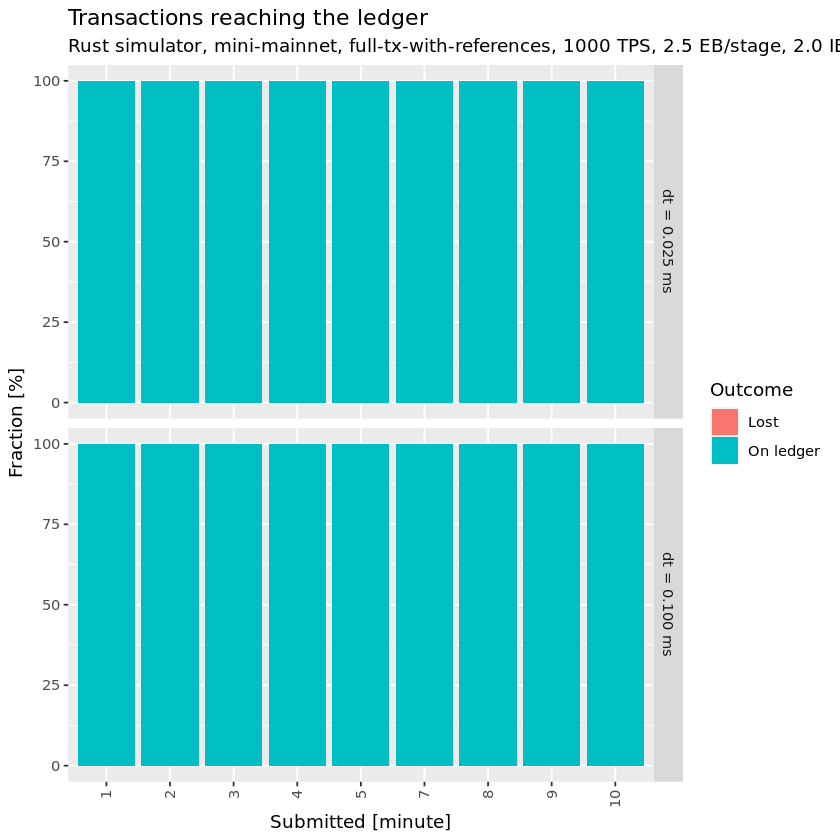

In [20]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`timestamp-resolution-ms`, `Submitted [minute]`)],
        id.vars=c("timestamp-resolution-ms", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[`Submitted [minute]` != 6, .(
        `timestamp-resolution-ms`,
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`timestamp-resolution-ms` ~ .) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [21]:
ggsave("plots/temporal-efficiency-bar.png", units="in", dpi=150, width=16, height=8)

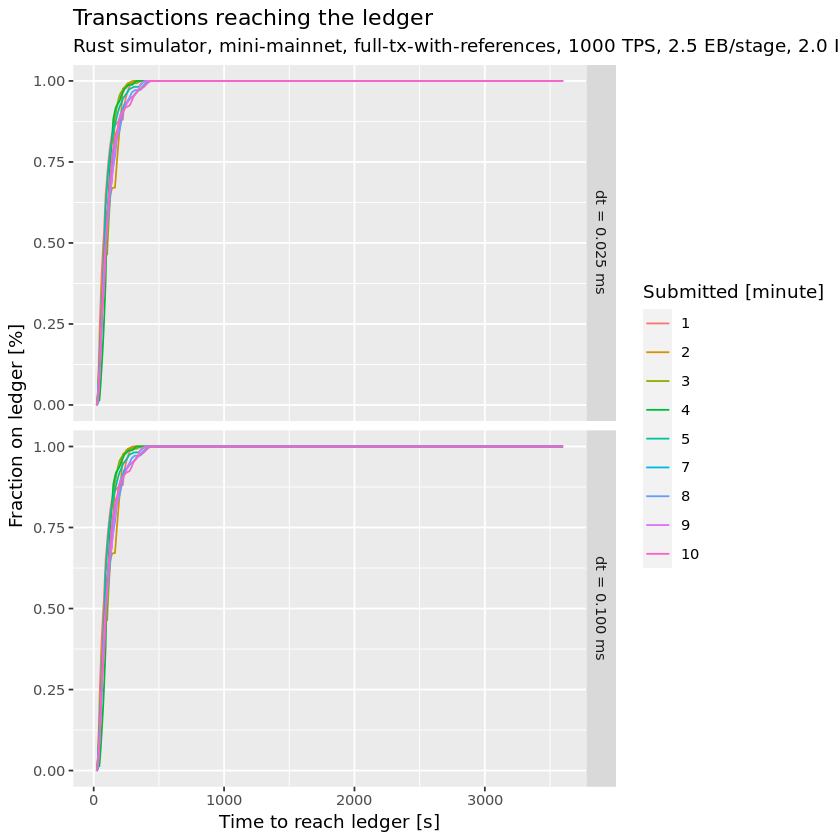

In [22]:
ggplot(
    rbind(
        totals[
            outcomes[
                !is.na(`Time to reach ledger [s]`), 
                .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), 
                .(`timestamp-resolution-ms`, `Submitted [minute]`)
            ],
            on=c("timestamp-resolution-ms", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`timestamp-resolution-ms`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`timestamp-resolution-ms`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 6],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`timestamp-resolution-ms` ~ .) +
    ggtitle("Transactions reaching the ledger", label)

In [23]:
ggsave("plots/temporal-efficiency-timeseries.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [24]:
rm(lifecycle, outcomes, totals)

In [25]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,966773,51.7,3010292,160.8,3010292,160.8
Vcells,5572073,42.6,66116008,504.5,82645009,630.6


### Resource usage

In [26]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(resources, file="results/resources.Rdata")
}
resources %>% summary

Loaded Rdata file: sampleSize = 1 


 Simulator    timestamp-resolution-ms       Node        Egress [B]       
 Rust:1500   dt = 0.025 ms:750        node-0  :   2   Min.   :1.687e+05  
             dt = 0.100 ms:750        node-1  :   2   1st Qu.:1.523e+07  
                                      node-10 :   2   Median :1.504e+08  
                                      node-100:   2   Mean   :2.203e+08  
                                      node-101:   2   3rd Qu.:3.019e+08  
                                      node-102:   2   Max.   :1.441e+09  
                                      (Other) :1488                      
    Disk [B]      Total CPU [s]   Maximum CPU [s/s]
 Min.   :     0   Min.   :365.0   Min.   :1.208    
 1st Qu.:     0   1st Qu.:365.7   1st Qu.:1.545    
 Median :     0   Median :365.7   Median :1.552    
 Mean   : 33063   Mean   :365.7   Mean   :1.536    
 3rd Qu.: 61888   3rd Qu.:365.8   3rd Qu.:1.557    
 Max.   :241712   Max.   :366.7   Max.   :1.895    
                                            

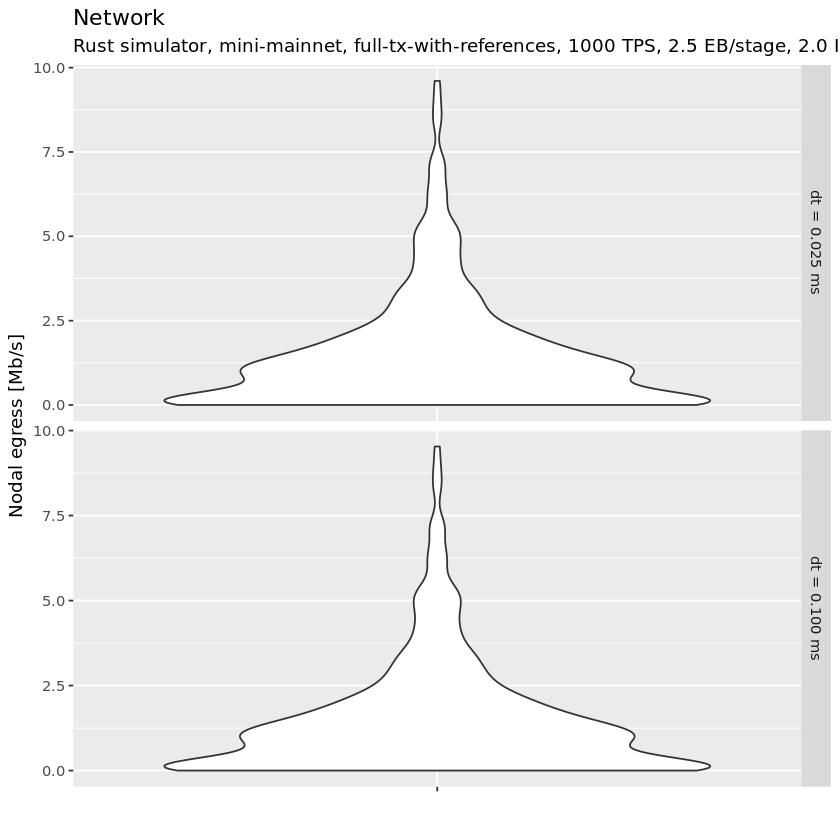

In [27]:
ggplot(
    resources[, .(`timestamp-resolution-ms`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_grid(`timestamp-resolution-ms` ~ ., scales="free_y") +
    xlab("") +
    ggtitle("Network", label)

In [28]:
ggsave("plots/network.png", units="in", dpi=150, width=16, height=8)

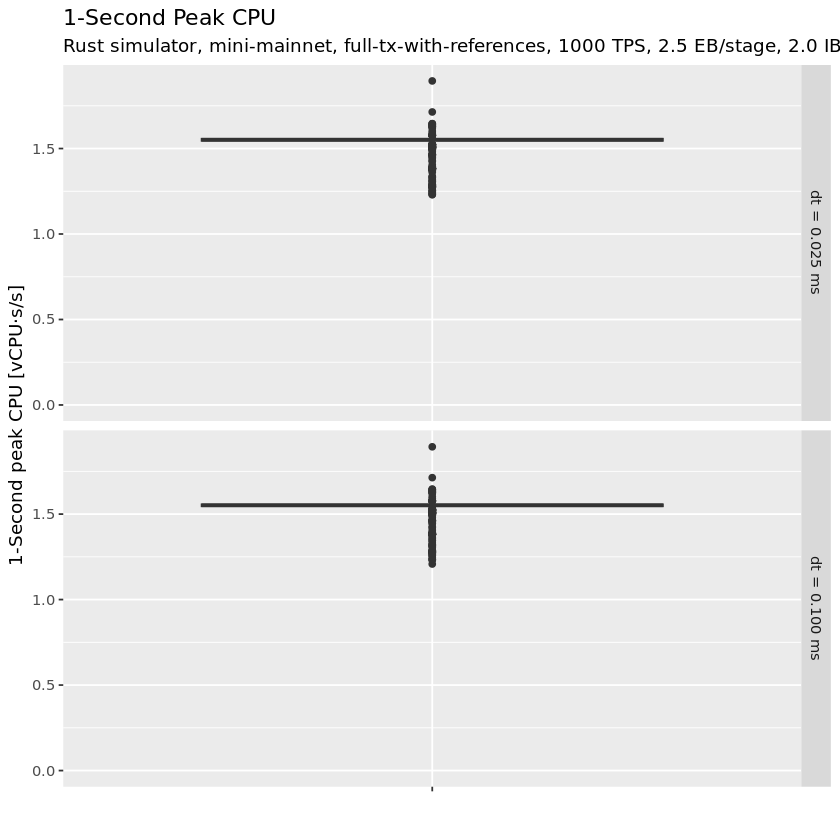

In [29]:
ggplot(
    resources[, .(`Node`, `timestamp-resolution-ms`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`timestamp-resolution-ms` ~ .) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [30]:
ggsave("plots/cpu-peak.png", units="in", dpi=150, width=16, height=8)

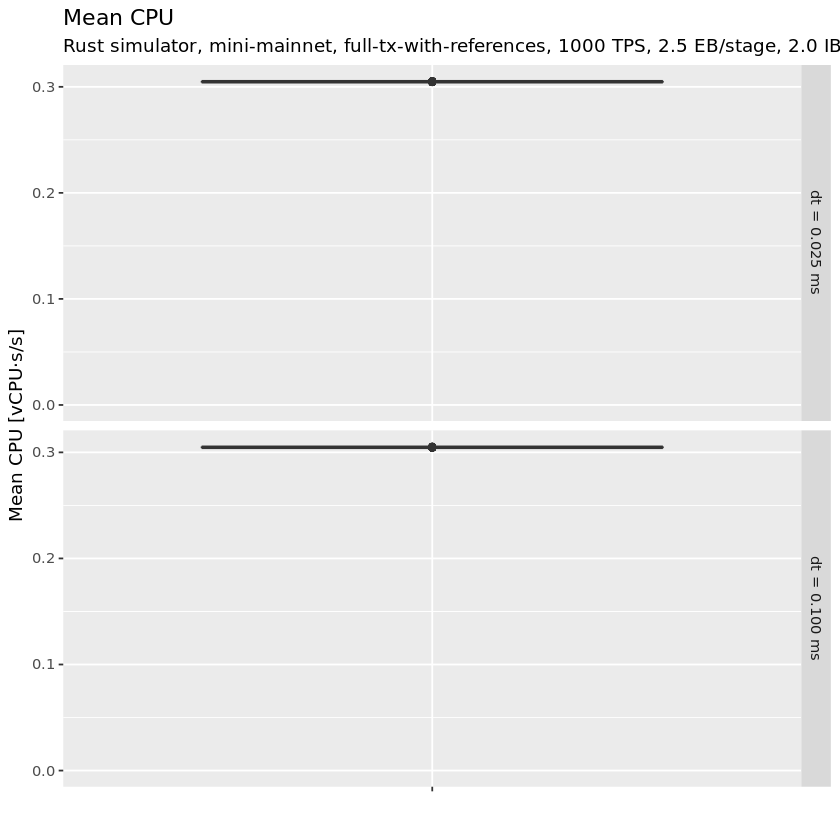

In [31]:
ggplot(
    resources[, .(`timestamp-resolution-ms`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`timestamp-resolution-ms` ~ .) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [32]:
ggsave("plots/cpu-mean.png", units="in", dpi=150, width=16, height=8)

#### Release memory

In [33]:
rm(resources)

In [34]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,996362,53.3,3010292,160.8,3010292,160.8
Vcells,2282090,17.5,52892807,403.6,82645009,630.6


### Receipt of messages

#### Read results

In [35]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(receipts, file="results/receipts.Rdata")
}
receipts %>% summary

Loaded Rdata file: sampleSize = 0.2 


 Simulator         timestamp-resolution-ms Kind          
 Rust:198418121   dt = 0.025 ms:99209060   EB:   178097  
                  dt = 0.100 ms:99209061   IB:   689281  
                                           RB:    21932  
                                           TX:185388624  
                                           VT: 12140187  
                                                         
                                                         
            Item               Producer         Generated [s]    
 1010-node-181:      675   node-695:   522544   Min.   :   1.13  
 960-node-143 :      660   node-383:   520341   1st Qu.: 214.08  
 985-node-430 :      659   node-681:   366732   Median : 368.95  
 655-node-94  :      657   node-338:   365975   Mean   : 377.30  
 1150-node-172:      655   node-11 :   365731   3rd Qu.: 524.80  
 610-node-150 :      655   node-108:   364564   Max.   :1198.13  
 (Other)      :198414160   (Other) :195912234                    
    Size

In [36]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB TX VT
Levels: EB IB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [37]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        rs[, .(`timestamp-resolution-ms`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`timestamp-resolution-ms` ~ ., scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

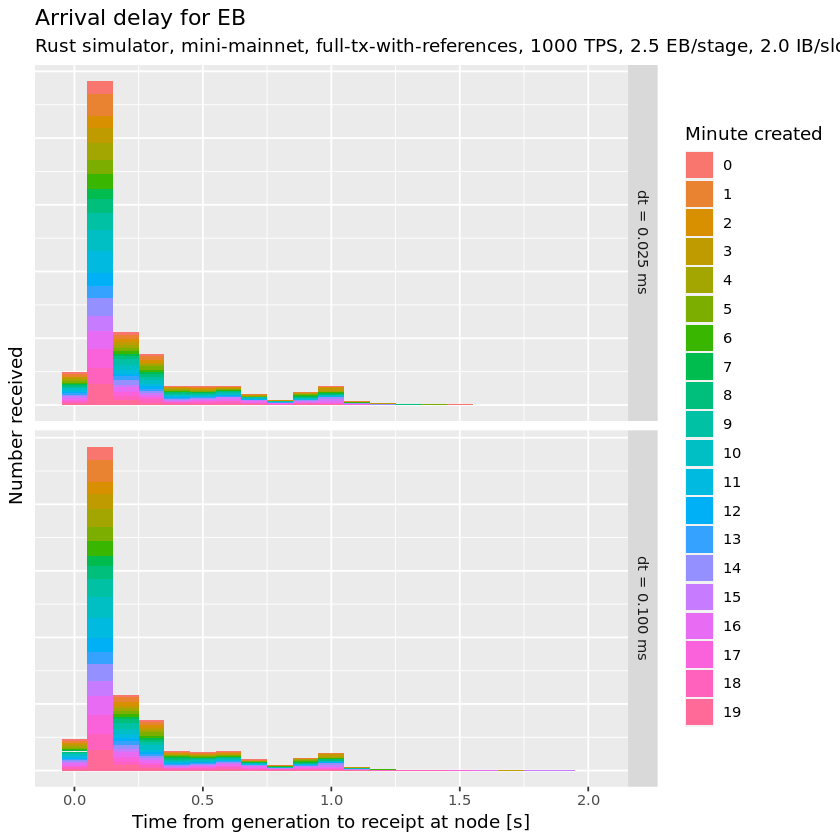

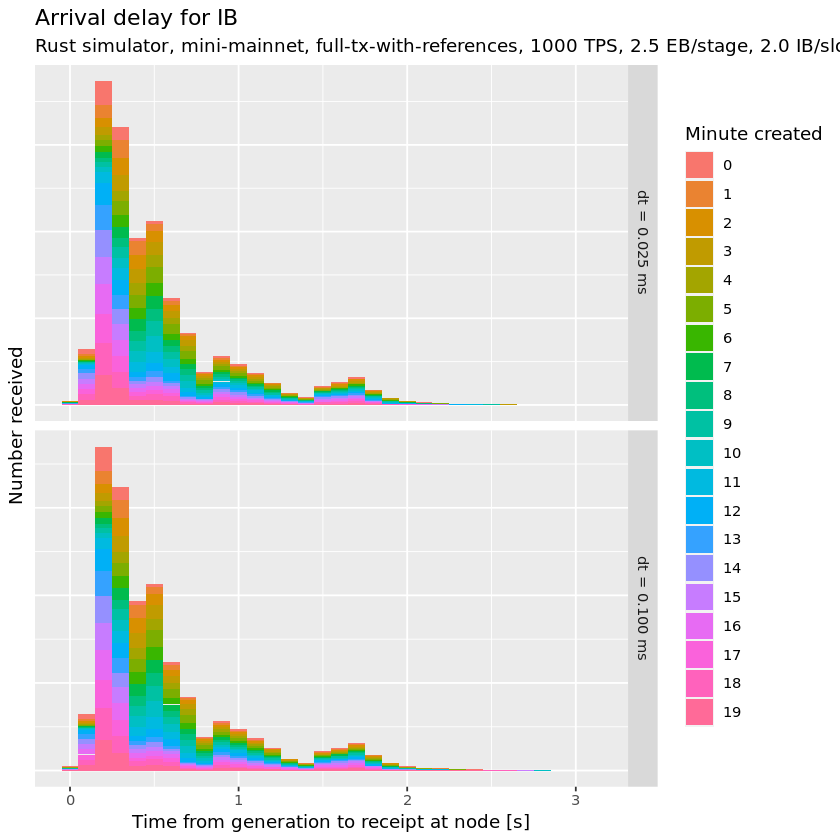

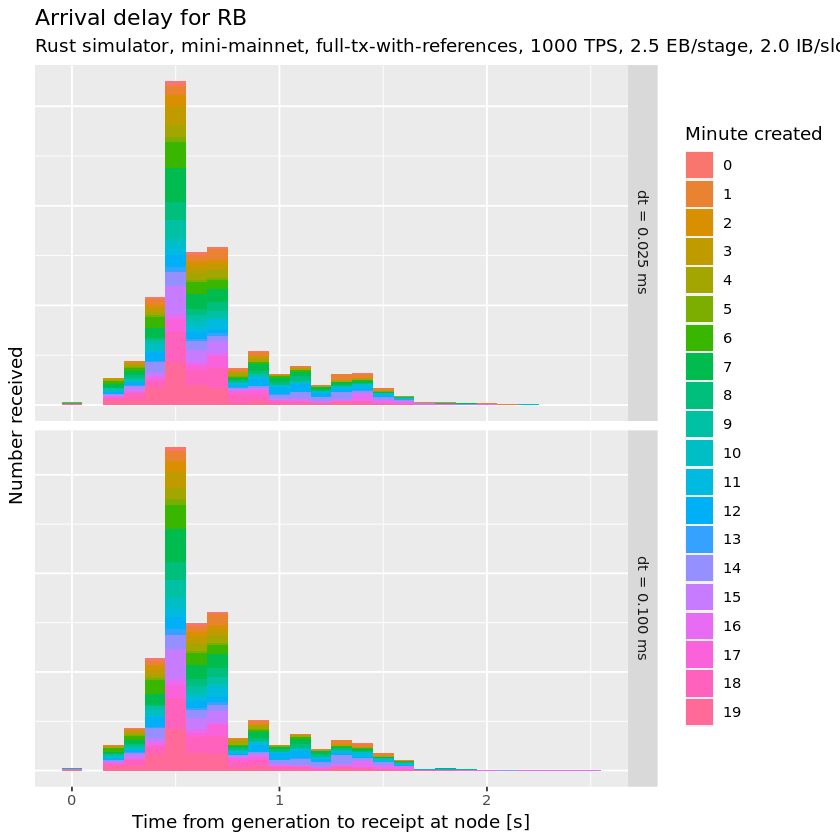

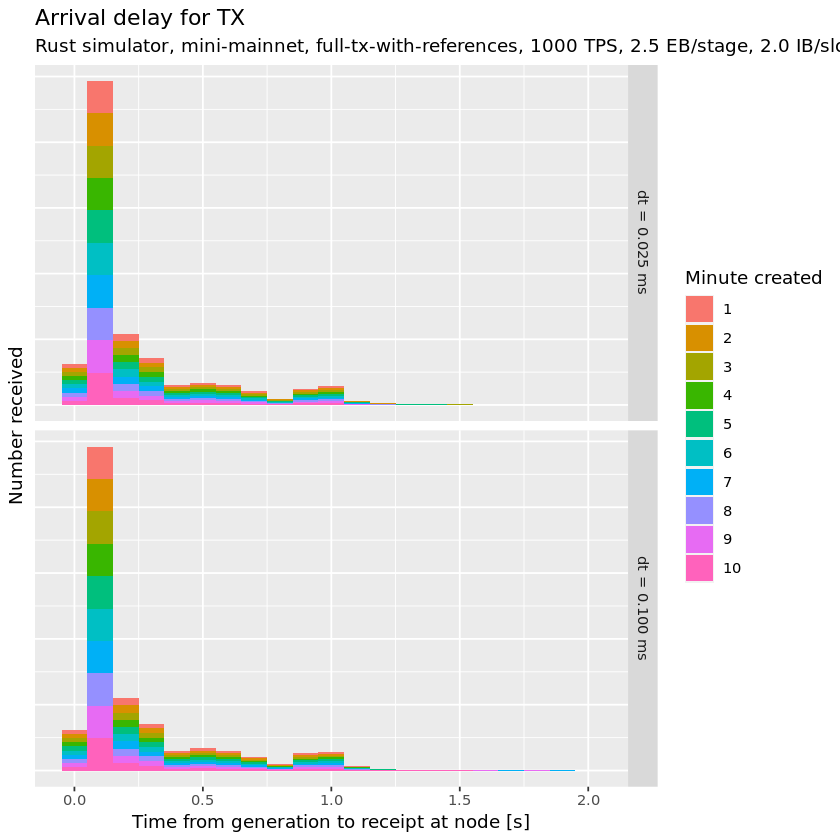

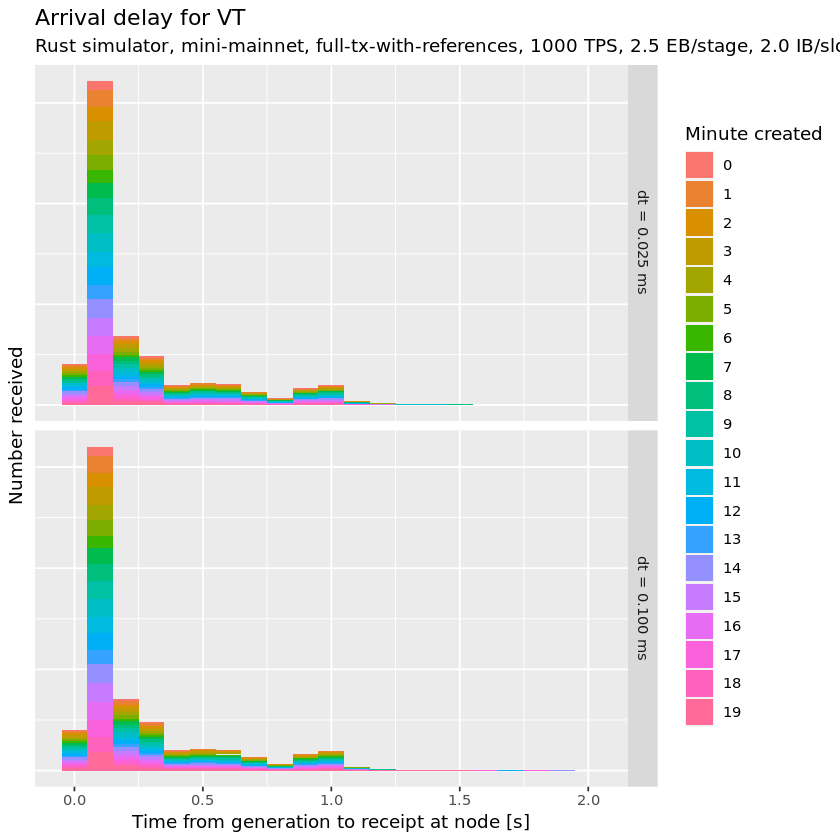

In [38]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/elapsed-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [39]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
            by=.(`timestamp-resolution-ms`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`timestamp-resolution-ms` ~ ., scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

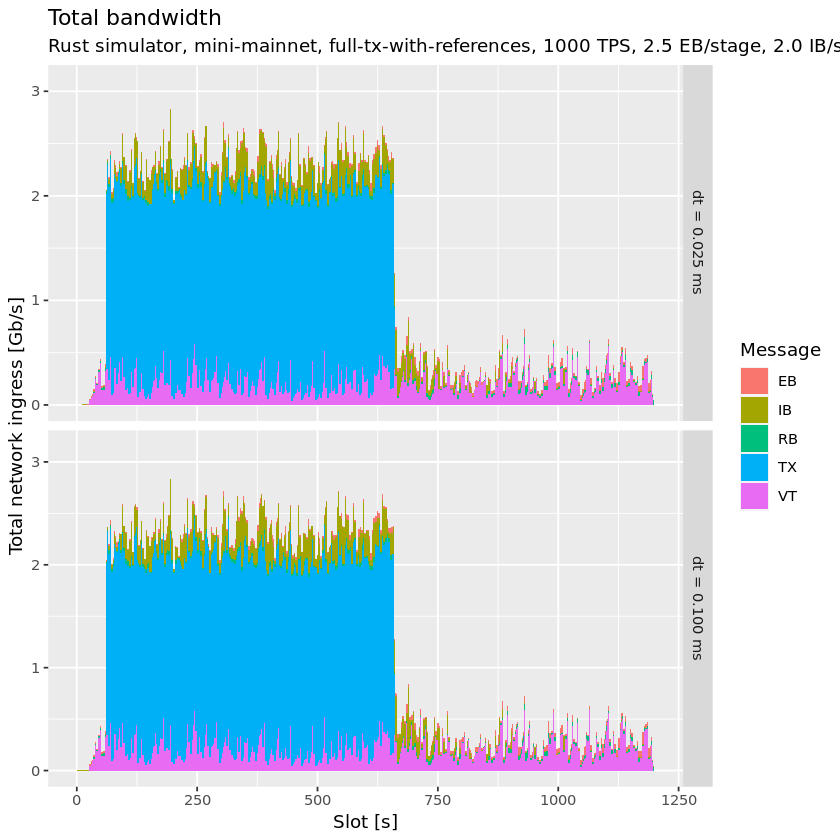

In [40]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="free_y",
    outfiles=paste0("plots/ingress-total-area.png")
)

##### Bandwidth usage per node

In [41]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [42]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount/sampleSize),
            by=.(`timestamp-resolution-ms`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`timestamp-resolution-ms` ~ ., scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

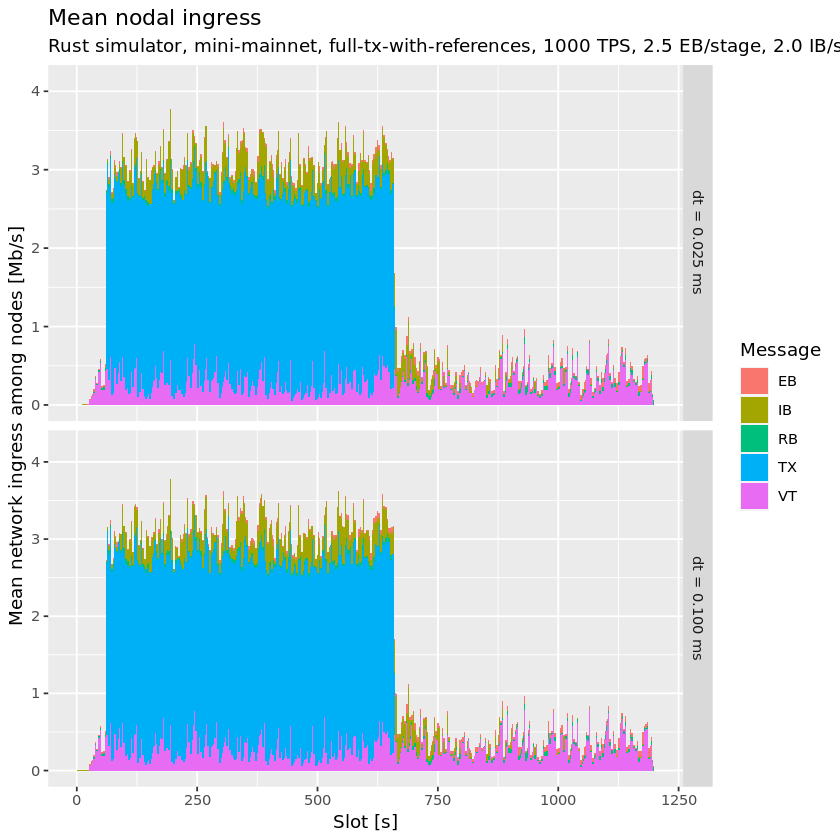

In [43]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="free_y",
    outfiles=paste0("plots/ingress-average-area.png")
)

In [44]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
            by=.(`timestamp-resolution-ms`, `Slot`=floor(`Received [s]`), `Message`=`Kind`, `Recipient`)
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`timestamp-resolution-ms`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`timestamp-resolution-ms` ~ ., scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

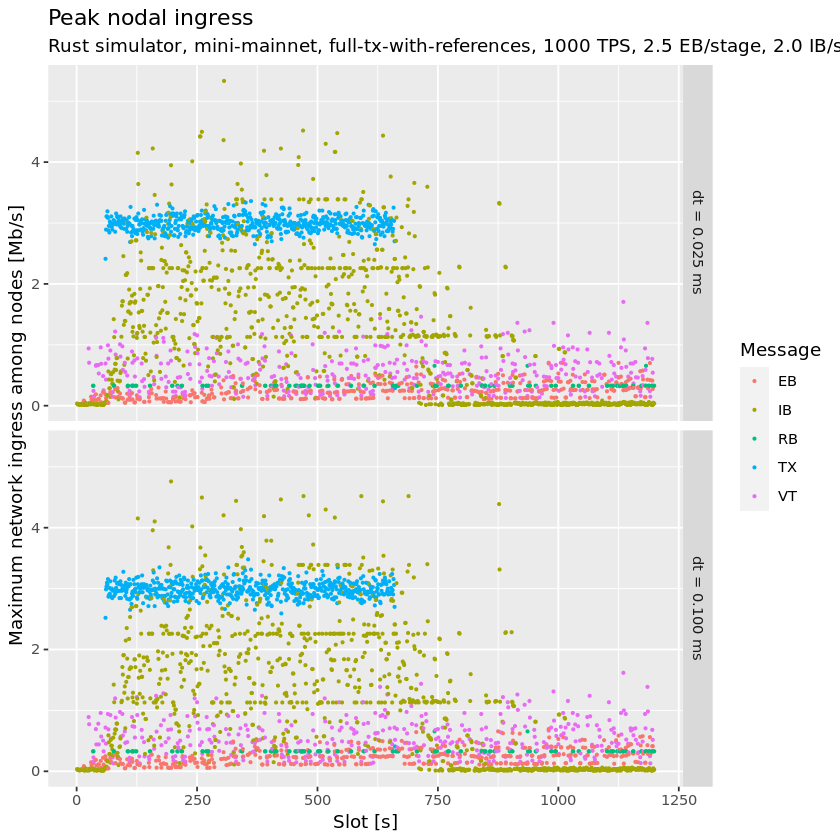

In [45]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/ingress-peak-point.png")
)

#### Release memory

In [46]:
rm(receipts)

In [47]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1669888,89.2,3010292,160.8,3010292,160.8
Vcells,1392615158,10624.9,4540564256,34641.8,7094611651,54127.6


### CPU usage

#### Read results

In [48]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(cpus, file="results/cpus.Rdata")
}
cpus %>% summary

Loaded Rdata file: sampleSize = 0.2 


 Simulator         timestamp-resolution-ms       Slot       
 Rust:220823260   dt = 0.025 ms:110411606   Min.   :   1.0  
                  dt = 0.100 ms:110411654   1st Qu.: 219.0  
                                            Median : 383.0  
                                            Mean   : 402.6  
                                            3rd Qu.: 548.0  
                                            Max.   :1200.0  
                                                            
       Node                Task            Duration [s]      
 node-133:   296011   ValTX  :185394049   Min.   :0.0000650  
 node-188:   295872   ValVote: 33810306   1st Qu.:0.0000650  
 node-605:   295827   ValIH  :   687755   Median :0.0000650  
 node-582:   295792   ValIB  :   685880   Mean   :0.0004964  
 node-50 :   295718   ValEB  :   177041   3rd Qu.:0.0000650  
 node-570:   295702   GenVote:    45149   Max.   :0.1810000  
 (Other) :219048338   (Other):    23080                      

In [49]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`timestamp-resolution-ms`, `Node`, `Slot`)
]

In [50]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [51]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`timestamp-resolution-ms`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`timestamp-resolution-ms` ~ ., scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

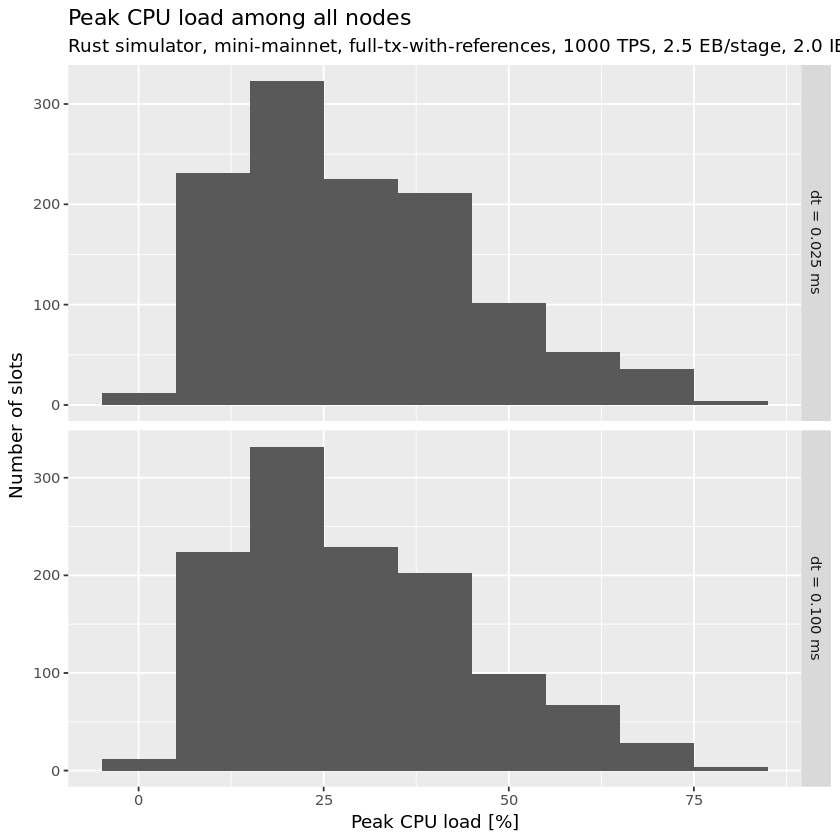

In [52]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/cpu-peak-histogram.png")
)

##### Time series

In [53]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
            by=.(`timestamp-resolution-ms`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`timestamp-resolution-ms` ~ ., scale=scales) +
#       scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

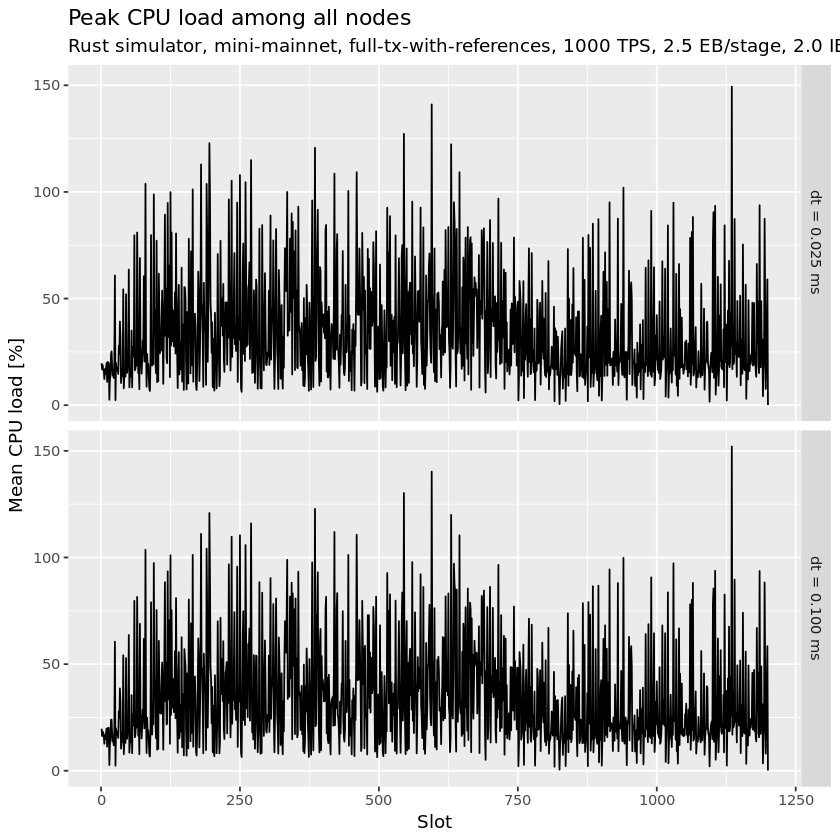

In [54]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [55]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`timestamp-resolution-ms`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`timestamp-resolution-ms` ~ ., scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

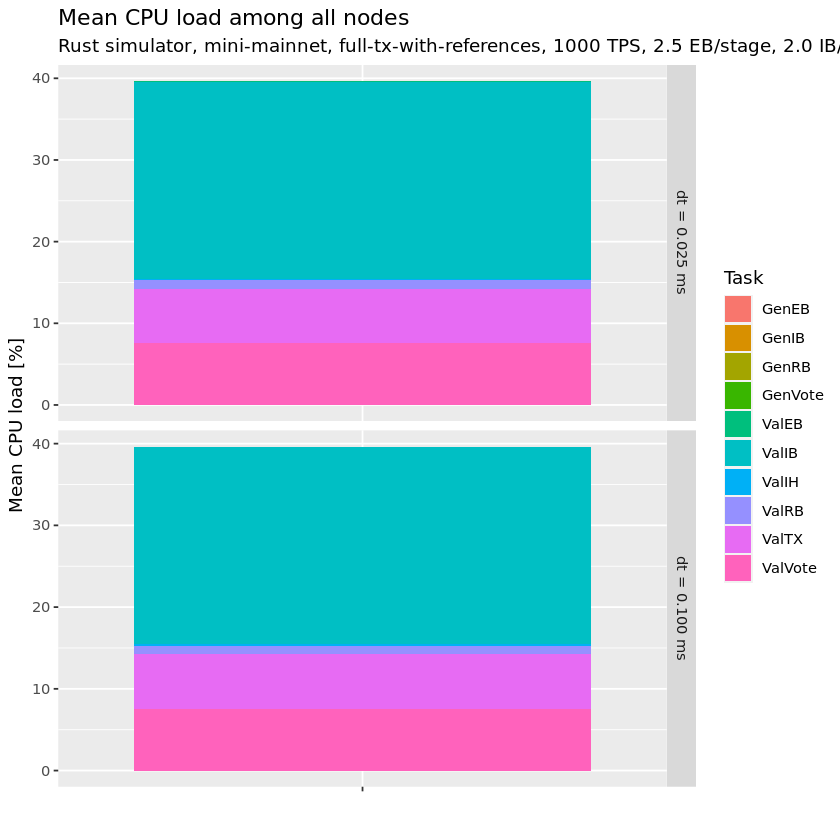

In [56]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/cpu-mean-histogram.png")
)

##### Time series

In [57]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=16, height=8, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`timestamp-resolution-ms`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`timestamp-resolution-ms` ~ ., scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

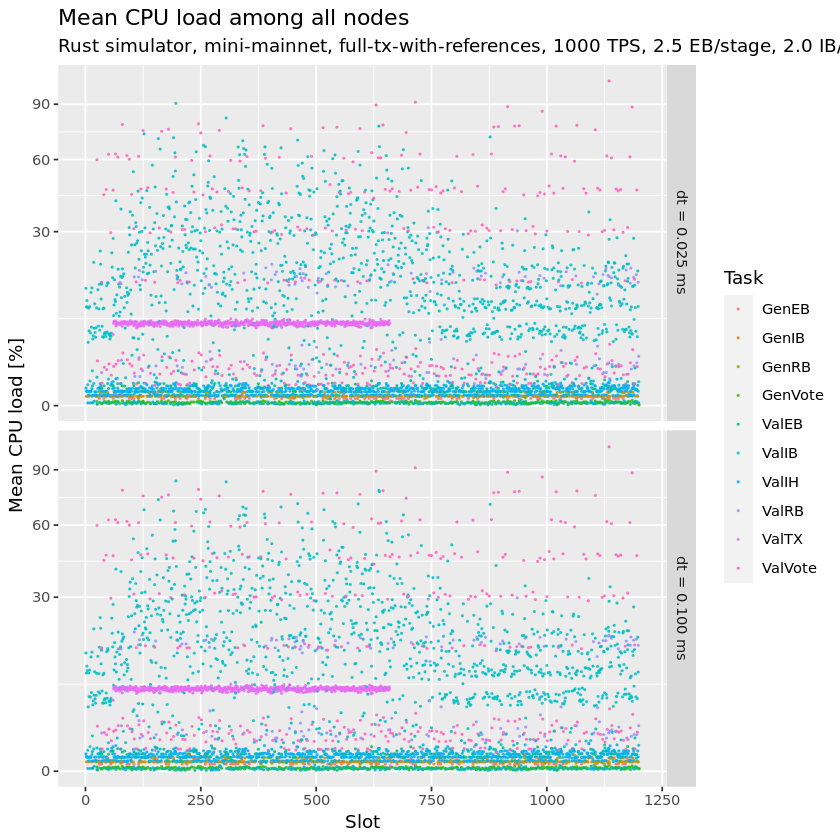

In [58]:
meanCpuTimeseries(
    cpus, 
    nodeCount * sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-mean-timeseries.png")
)

#### Release memory

In [59]:
rm(cpus, cpusNode)

In [60]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1011384,54.1,3010292,160.8,3010292,160.8
Vcells,775223577,5914.5,3632451405,27713.5,7094611651,54127.6
